In [1]:
import os
import re
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
try:
    import nltk
    from nltk.corpus import stopwords
    from nltk.stem import PorterStemmer
    nltk.data.find('tokenizers/punkt')
except LookupError:
    print("⚠️ NLTK resources not found. Downloading...")
    nltk.download('stopwords', quiet=True)
    nltk.download('punkt', quiet=True)

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

⚠️ NLTK resources not found. Downloading...


In [4]:
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

In [5]:
def preprocess_text(text):
    """Clean and normalize text for ML."""
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    words = text.split()
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    return ' '.join(words)

Loading dataset...
Loaded 5572 messages.
label
ham     4825
spam     747
Name: count, dtype: int64

 Preprocessing text...
Train size: 4457, Test size: 1115

 Vectorizing text with TF-IDF...

 Training Logistic Regression model...

 Accuracy: 0.9632 (96.32%)

 Classification Report:
              precision    recall  f1-score   support

         Ham       0.96      1.00      0.98       966
        Spam       0.99      0.73      0.84       149

    accuracy                           0.96      1115
   macro avg       0.98      0.87      0.91      1115
weighted avg       0.96      0.96      0.96      1115

📸 Confusion matrix saved as 'confusion_matrix.png'

 Model and vectorizer saved as 'model.pkl' and 'tfidf_vectorizer.pkl'

 Demo Predictions:
Text: "Congratulations! You've won a $1000 gift card. Click here to claim now!" → Prediction: Ham (Confidence: 0.56)
Text: "Hey, are we still meeting for lunch tomorrow?" → Prediction: Ham (Confidence: 0.98)
Text: "URGENT! Your account has been su

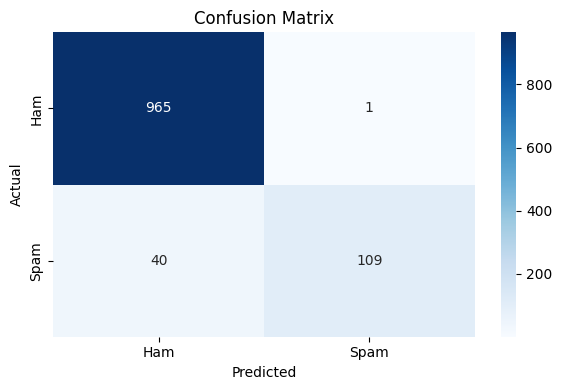

In [6]:
def main():
    # Load Dataset
    dataset_path = 'spam.csv'
    if not os.path.exists(dataset_path):
        print("Error: 'spam.csv' not found in the current directory.")
        print("Please download it from: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset")
        print("Place it in:", os.getcwd())
        return

    print("Loading dataset...")
    df = pd.read_csv(dataset_path, encoding='latin-1')
    df = df[['v1', 'v2']].rename(columns={'v1': 'label', 'v2': 'message'})

    print(f"Loaded {len(df)} messages.")
    print(df['label'].value_counts())

    #  Preprocess Text
    print("\n Preprocessing text...")
    df['cleaned'] = df['message'].apply(preprocess_text)

    # Encode Labels & Split Data
    df['label_encoded'] = df['label'].map({'ham': 0, 'spam': 1})
    X = df['cleaned']
    y = df['label_encoded']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

    # TF-IDF Vectorization
    print("\n Vectorizing text with TF-IDF...")
    tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
    X_train_tfidf = tfidf.fit_transform(X_train)
    X_test_tfidf = tfidf.transform(X_test)

    # Train Model
    print("\n Training Logistic Regression model...")
    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(X_train_tfidf, y_train)

    # Evaluate Model
    y_pred = model.predict(X_test_tfidf)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n Accuracy: {acc:.4f} ({acc*100:.2f}%)")

    print("\n Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    print("📸 Confusion matrix saved as 'confusion_matrix.png'")

    # Save Model & Vectorizer
    with open('model.pkl', 'wb') as f:
        pickle.dump(model, f)
    with open('tfidf_vectorizer.pkl', 'wb') as f:
        pickle.dump(tfidf, f)
    print("\n Model and vectorizer saved as 'model.pkl' and 'tfidf_vectorizer.pkl'")

    # Demo Prediction Function
    def predict_sms(text):
        cleaned = preprocess_text(text)
        vec = tfidf.transform([cleaned])
        pred = model.predict(vec)[0]
        prob = model.predict_proba(vec)[0]
        label = "Spam" if pred == 1 else "Ham"
        confidence = max(prob)
        return label, confidence

    print("\n Demo Predictions:")
    test_msgs = [
        "Congratulations! You've won a $1000 gift card. Click here to claim now!",
        "Hey, are we still meeting for lunch tomorrow?",
        "URGENT! Your account has been suspended. Verify immediately."
    ]
    for msg in test_msgs:
        label, conf = predict_sms(msg)
        print(f"Text: \"{msg}\" → Prediction: {label} (Confidence: {conf:.2f})")

    print("\n Task 1: Spam SMS Detection completed successfully!")
    print("Next steps:")
    print("  - Record a demo video of this script running")
    print("  - Post on LinkedIn with @CodSoft and #codsoft")
    print("  - Push all files to your GitHub CODSOFT repo")


if __name__ == "__main__":
    main()